In [258]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import matplot2tikz

In [259]:
# Path to your event files
experiment_path = "../../runs/sac/winrate_runs/*/*"
event_files = glob.glob(experiment_path, recursive=True)

all_data = []
dfs_from_csv = []
for file in event_files:
    print(file)
    if file.endswith("0"):
        for e in tf.compat.v1.train.summary_iterator(file):
            for v in e.summary.value:
                if v.HasField('simple_value'):  # Scalars only
                    all_data.append({
                        'file': os.path.basename(file),
                        "path": file,
                        'tag': v.tag,
                        'step': e.step,
                        'value': v.simple_value
                    })

df_sac = pd.DataFrame(all_data)
df_td3 = pd.read_csv(r"../../runs/sac/winrate_runs\td3\rnd_0x5-1_strong_opp_combined_metrics.csv")
df_td3["path"] = r"../../runs/sac/winrate_runs\td3\rnd_0x5-1_strong_opp_combined_metrics.csv"
df_crq = pd.read_csv(r"../../runs/sac/winrate_runs\crq\res.csv")
df_crq["path"] = r"../../runs/sac/winrate_runs\crq\res.csv"


../../runs/sac/winrate_runs\crq\res.csv
../../runs/sac/winrate_runs\sac\events.out.tfevents.1771972390.tcml-node39.1023698.0
../../runs/sac/winrate_runs\td3\rnd_0x5-1_strong_opp_combined_metrics.csv


In [260]:
tag = "charts/winrate_raw"
df_filtered = df_sac[df_sac['tag'] == tag]
df_filtered = df_filtered[["path", "step", "value"]]
df_filtered["algorithm"] = df_filtered["path"].str.slice(28, 31)

In [261]:
print(df_filtered.head())

                                                 path  step  value algorithm
4   ../../runs/sac/winrate_runs\sac\events.out.tfe...    27   -1.0       sac
9   ../../runs/sac/winrate_runs\sac\events.out.tfe...    28   -1.0       sac
14  ../../runs/sac/winrate_runs\sac\events.out.tfe...    29   -1.0       sac
19  ../../runs/sac/winrate_runs\sac\events.out.tfe...    31   -1.0       sac
24  ../../runs/sac/winrate_runs\sac\events.out.tfe...    33   -1.0       sac


In [262]:
df_filtered["win"] = df_filtered["value"] == 1
df_filtered["loss"] = df_filtered["value"] == -1
df_filtered["draw"] = df_filtered["value"] == 0

df_filtered["winrate"] = df_filtered["win"].rolling(window=50).mean()
df_filtered["lossrate"] = df_filtered["loss"].rolling(window=50).mean()
df_filtered["drawrate"] = df_filtered["draw"].rolling(window=50).mean()

df_no_draw = df_filtered[df_filtered["draw"]==False].copy()

df_no_draw["winrate_no_draw"] = df_no_draw["win"].rolling(window=50).mean()

df_filtered = df_filtered[["winrate", "lossrate", "drawrate", "algorithm", "step"]]
df_sac = df_filtered

In [263]:

df_td3["algorithm"] = df_td3["path"].str.slice(28, 31)
df_td3 = df_td3.rename(columns={"win_rate": "winrate", "draw_rate": "drawrate", "lose_rate": "lossrate", "loserate":"lossrate"})
df_td3 = df_td3[["winrate", "lossrate", "drawrate", "algorithm", "step"]]
df_crq["algorithm"] = df_crq["path"].str.slice(28, 31)
df_crq = df_crq.rename(columns={"win_rate": "winrate", "draw_rate": "drawrate", "lose_rate": "lossrate", "loserate":"lossrate"})
df_crq = df_crq[["winrate", "lossrate", "drawrate", "algorithm", "step"]]
df_crq = df_crq[df_crq["step"]<4e5]

print(df_crq.head())
print(df_td3.head())


   winrate  lossrate  drawrate algorithm  step
0     0.13      0.42      0.45       crq  1759
1     0.14      0.41      0.47       crq  1780
2     0.14      0.42      0.47       crq  1788
3     0.12      0.42      0.46       crq  1844
4     0.12      0.44      0.46       crq  1844
   winrate  lossrate  drawrate algorithm   step
0      0.0       0.5       0.5       td3  26000
1      0.0       0.4       0.6       td3  27000
2      0.2       0.6       0.2       td3  28000
3      0.1       0.6       0.3       td3  29000
4      0.2       0.6       0.2       td3  30000


In [264]:

df_td3 = df_td3.iloc[::5, :]
df_sac = df_sac.iloc[::100, :]
df_crq = df_crq.iloc[::100, :]
dfs_cat = pd.concat([df_crq, df_sac, df_td3])
dfs_cat = dfs_cat.sort_values("step")

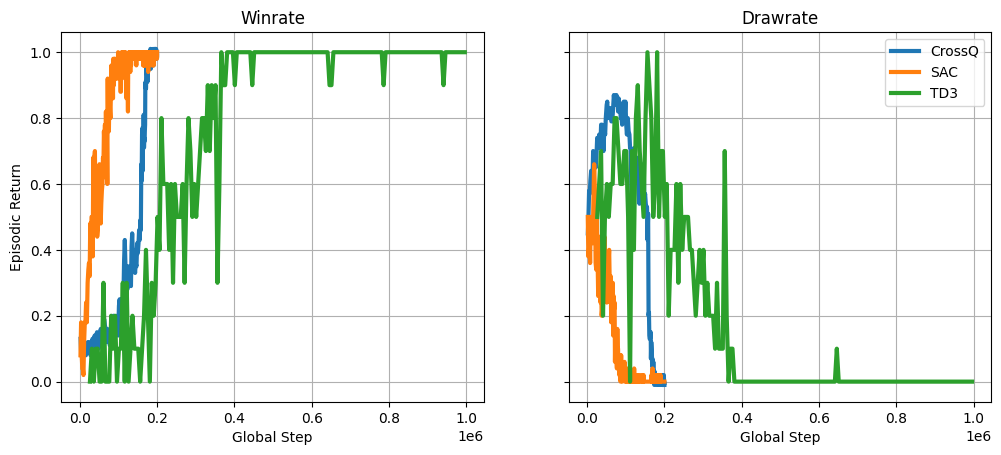

In [268]:
fig, ax = plt.subplots(ncols=2, sharey=True)
tab10 = plt.get_cmap('tab10')
labels = ["CrossQ", "SAC", "TD3"]
for index, g in enumerate(dfs_cat.groupby("algorithm")):
    ax[0].plot(g[1]["step"], g[1]["winrate"], label=labels[index], color=tab10(index), linewidth=3)
    ax[0].set_title("Winrate")
    ax[1].plot(g[1]["step"], g[1]["drawrate"], label=labels[index], color=tab10(index), linewidth=3)
    ax[1].set_title("Drawrate")
"""for index, g in enumerate(df_no_draw.groupby("path")):
    ax[3].set_title("Winrate no draw")
    ax[3].plot(g[1]["step"], g[1]["winrate_no_draw"], label=g[0], color=tab10(index), linewidth=2)"""
for ax_i in ax:
    ax_i.grid(True)

fig.set_figwidth(12)
ax[0].set_xlabel("Global Step")
ax[1].set_xlabel("Global Step")
ax[0].set_ylabel("Episodic Return")
plt.legend()
plt.show()

In [269]:
matplot2tikz.save("exp_comp.tikz", figure=fig)